In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Define the directory containing XML files
dataset_dir = '/home/kali/Documents/telecom/exo5/ISCXIDS2012 dataset/labeled_flows_xml/lightfolder'

# Initialize lists to store feature and label data
normal_features = []
normal_labels = []
attack_features = []
attack_labels = []
# Iterate over all files in the directory
for xml_file in os.listdir(dataset_dir):
    # Load XML data into a DataFrame
    data_frame = pd.read_xml(os.path.join(dataset_dir, xml_file))
    print(data_frame.info())  # Print DataFrame info for debugging (optional)

    # Use the updated approach for value counts
    app_count = pd.Series(data_frame['appName']).value_counts()

    # Count occurrences in the 'Tag' column
    attack_count = pd.Series(data_frame['Tag']).value_counts()

    # Separate rows by the 'Tag' column (Attack or Normal)
    attack_data = data_frame[data_frame['Tag'] == 'Attack']

    # Count appName occurrences in the Attack DataFrame
    attack_app_count = pd.Series(attack_data['appName']).value_counts()

    # Separate Normal data rows
    normal_data = data_frame[data_frame['Tag'] == 'Normal']

    # Extract feature columns for both Attack and Normal data
    attack_features_df = attack_data[['totalSourceBytes', 'totalDestinationBytes', 
                                       'totalDestinationPackets', 'totalSourcePackets', 
                                       'sourcePort', 'destinationPort']]
    normal_features_df = normal_data[['totalSourceBytes', 'totalDestinationBytes', 
                                       'totalDestinationPackets', 'totalSourcePackets', 
                                       'sourcePort', 'destinationPort']]

    # Extract labels for Attack and Normal data
    attack_labels_df = attack_data[['Tag']]
    normal_labels_df = normal_data[['Tag']]

    # Append the processed data to the respective lists
    attack_features.append(attack_features_df)
    attack_labels.append(attack_labels_df)
    normal_features.append(normal_features_df)
    normal_labels.append(normal_labels_df)

# Concatenate all collected data into single DataFrames
X_Normal = pd.concat(normal_features, ignore_index=True)
Y_Normal = pd.concat(normal_labels, ignore_index=True)
X_Attack = pd.concat(attack_features, ignore_index=True)
Y_Attack = pd.concat(attack_labels, ignore_index=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133193 entries, 0 to 133192
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   appName                         133193 non-null  object
 1   totalSourceBytes                133193 non-null  int64 
 2   totalDestinationBytes           133193 non-null  int64 
 3   totalDestinationPackets         133193 non-null  int64 
 4   totalSourcePackets              133193 non-null  int64 
 5   sourcePayloadAsBase64           70040 non-null   object
 6   sourcePayloadAsUTF              70040 non-null   object
 7   destinationPayloadAsBase64      68042 non-null   object
 8   destinationPayloadAsUTF         68041 non-null   object
 9   direction                       133193 non-null  object
 10  sourceTCPFlagsDescription       94981 non-null   object
 11  destinationTCPFlagsDescription  90822 non-null   object
 12  source                        

In [9]:
from sklearn.model_selection import train_test_split

X_train_N, X_test_N, Y_train_N, Y_test_N = train_test_split(X_Normal, Y_Normal, test_size=0.3, random_state=0)
X_train_A, X_test_A, Y_train_A, Y_test_A = train_test_split(X_Attack, Y_Attack, test_size=0.3, random_state=0)

X_train = pd.concat([X_train_N, X_train_A])
X_train = X_train.sample(frac=1, random_state=42)

X_test = pd.concat([X_test_N, X_test_A])
X_test = X_test.sample(frac=1, random_state=42)

Y_train = np.concatenate([Y_train_N, Y_train_A])
Y_train = pd.DataFrame(Y_train)
Y_train = Y_train.sample(frac=1, random_state=42)

Y_test = np.concatenate([Y_test_N, Y_test_A])
Y_test = pd.DataFrame(Y_test)
Y_test = Y_test.sample(frac=1, random_state=42)

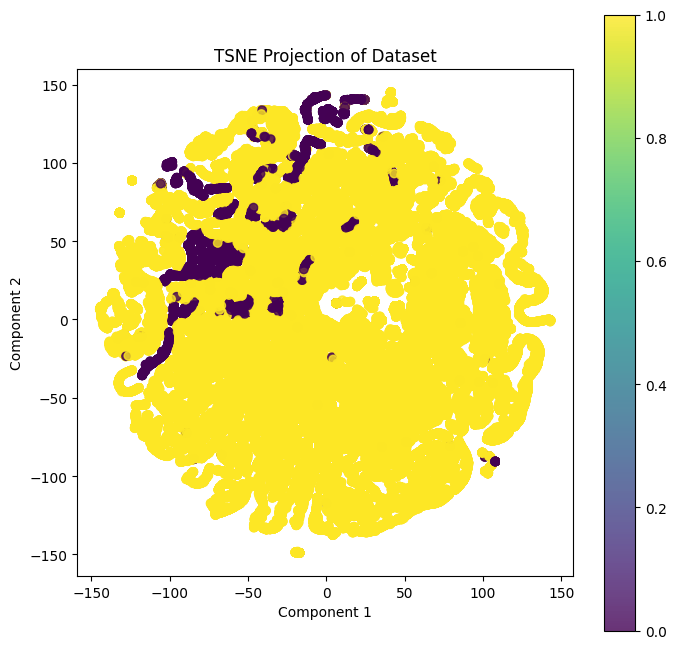

10-Fold Cross-Validation Accuracy: 0.9995
Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      6734
     Attacks       1.00      1.00      1.00    115884

    accuracy                           1.00    122618
   macro avg       1.00      1.00      1.00    122618
weighted avg       1.00      1.00      1.00    122618

Confusion Matrix:
[[  6709     25]
 [    44 115840]]
Precision (Weighted): 0.9994
Recall (Weighted): 0.9994
F1 Score (Macro): 0.9973


In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd

# Dimensionality reduction for visualization
dim_reduction_model = TSNE
data_for_viz = X_test

# Apply the dimensionality reduction
reducer = dim_reduction_model(n_components=2)
reduced_data = reducer.fit_transform(data_for_viz)

# Prepare labels for plotting
labels_df = pd.DataFrame(Y_test)
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of the reduced data
scatter = ax.scatter(
    reduced_data[:, 0], 
    reduced_data[:, 1], 
    c=labels_df[0].astype('category').cat.codes, 
    cmap='viridis',
    alpha=0.8
)

# Set plot attributes
ax.set(
    aspect='equal',
    xlabel='Component 1',
    ylabel='Component 2',
    title=f'{dim_reduction_model.__name__} Projection of Dataset'
)
plt.colorbar(scatter)
plt.show()

# Train a decision tree classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, Y_train)

# Perform cross-validation
cv_strategy = KFold(n_splits=10, random_state=42, shuffle=True)
validation_accuracy = cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv=cv_strategy, n_jobs=-1)
print(f"10-Fold Cross-Validation Accuracy: {validation_accuracy.mean():.4f}")

# Evaluate the model
test_accuracy = classifier.score(X_test, Y_test)
predictions = classifier.predict(X_test)

# Calculate performance metrics
conf_matrix = confusion_matrix(Y_test, predictions)
weighted_precision = precision_score(Y_test, predictions, average='weighted', labels=np.unique(predictions))
weighted_recall = recall_score(Y_test, predictions, average='weighted', labels=np.unique(predictions))
macro_f1 = f1_score(Y_test, predictions, average='macro', labels=np.unique(predictions))

# Display the classification report
print("Classification Report:")
print(classification_report(Y_test, predictions, target_names=['Normal', 'Attacks']))

# Display additional metrics
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision (Weighted): {weighted_precision:.4f}")
print(f"Recall (Weighted): {weighted_recall:.4f}")
print(f"F1 Score (Macro): {macro_f1:.4f}")


In [13]:
conf_matrix

array([[  6709,     25],
       [    44, 115840]])

In [14]:
# Calculate false alert rate
false_alert_rate = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[0][0])
print(f"False alert rate: {false_alert_rate}")

False alert rate: 0.0037125037125037125


In [16]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Define the path to the dataset folder
dataset_path = "/home/kali/Documents/telecom/exo5/ISCXIDS2012 dataset/labeled_flows_xml/lightfolder"

# Step 2: Load and Combine XML Files
columns_to_keep = ['totalSourceBytes', 'totalDestinationBytes', 'totalDestinationPackets',
                   'totalSourcePackets', 'sourcePort', 'destinationPort', 'Tag']
data_frames = []

# Process each XML file in the folder
for xml_file in os.listdir(dataset_path):
    xml_file_path = os.path.join(dataset_path, xml_file)
    df = pd.read_xml(xml_file_path, parser='lxml')
    data_frames.append(df)

# Combine all data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

# Step 3: Separate Features and Target Variable
selected_features = ['totalSourceBytes', 'totalDestinationBytes', 'totalDestinationPackets',
                     'totalSourcePackets', 'sourcePort', 'destinationPort']
combined_data[selected_features] = combined_data[selected_features].astype('int64')  # Ensure integer type

X = combined_data[selected_features]
y = combined_data['Tag']

# Step 4: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Balance the Training Data Using SMOTE
oversampler = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

# Step 6: Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_balanced, y_train_balanced)

# Step 7: Cross-Validation Evaluation
cv_strategy = KFold(n_splits=10, random_state=42, shuffle=True)
cv_accuracy = cross_val_score(rf_classifier, X_train_balanced, y_train_balanced, scoring='accuracy', cv=cv_strategy, n_jobs=-1)
print(f"10-Fold CV Accuracy for Random Forest: {cv_accuracy.mean():.4f}")

# Step 8: Model Evaluation on Test Data
predictions = rf_classifier.predict(X_test)

# Metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\nClassification Report:")
print(classification_report(y_test, predictions))

weighted_precision = precision_score(y_test, predictions, average='weighted', labels=np.unique(predictions))
weighted_recall = recall_score(y_test, predictions, average='weighted', labels=np.unique(predictions))
macro_f1_score = f1_score(y_test, predictions, average='macro', labels=np.unique(predictions))

print(f"Precision: {weighted_precision:.4f}, Recall: {weighted_recall:.4f}, F1-Score (Macro): {macro_f1_score:.4f}")

# Step 9: Calculate False Alert Rate
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, predictions).ravel()
false_positive_rate = false_positives / (false_positives + true_negatives)
print(f"False Positive Rate: {false_positive_rate:.4f}")


/home/kali/Documents/telecom/.telecom/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/kali/Documents/telecom/.telecom/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


10-Fold CV Accuracy for Random Forest: 0.9989

Confusion Matrix:
[[  6592     35]
 [    15 115975]]

Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      0.99      1.00      6627
      Normal       1.00      1.00      1.00    115990

    accuracy                           1.00    122617
   macro avg       1.00      1.00      1.00    122617
weighted avg       1.00      1.00      1.00    122617

Precision: 0.9996, Recall: 0.9996, F1-Score (Macro): 0.9980
False Positive Rate: 0.0053
